In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gcvit
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download vivektalwar13071999/final-oralv1

 98% 1.03G/1.05G [00:08<00:00, 143MB/s]
100% 1.05G/1.05G [00:09<00:00, 125MB/s]


In [9]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!unzip /content/final-oralv1.zip

Archive:  /content/final-oralv1.zip
  inflating: final_oral/test/non-suspicious/1_0GMsu0AKOlhyYfpSr5DGMJRZLlzwVuFj.jpg  
  inflating: final_oral/test/non-suspicious/1_0Jtkq6tpjENPYGcmwOEeF1kv5yTelaUi.jpg  
  inflating: final_oral/test/non-suspicious/1_0hFhiB4U85CWQYBHYDmkNq14whOOKX6G.jpg  
  inflating: final_oral/test/non-suspicious/1_0jVhFFCsdUtUEC1Ao6KW555kyfSnRxjA.jpg  
  inflating: final_oral/test/non-suspicious/1_11CxWXdQLKtNda92rfxBGQoYFEwrUlVT.jpg  
  inflating: final_oral/test/non-suspicious/1_16ipgfD9jYe9JFy5RO8yeWnYmGfBbxoF.jpg  
  inflating: final_oral/test/non-suspicious/1_19e1bzOUVdJqdTneNkJXcJw32eDNnU9d.jpg  
  inflating: final_oral/test/non-suspicious/1_1Db0wCHeLVAFqDructEaSj6vX6PKMzN3.jpg  
  inflating: final_oral/test/non-suspicious/1_22XKwuf5tBsGQv6f6WdvoVSMYJhmANnk.jpg  
  inflating: final_oral/test/non-suspicious/1_27bd9bTcsiDex4b8W595lpl0aNUpHpvC.jpg  
  inflating: final_oral/test/non-suspicious/1_2ak4W1TUxHZAN823iH19zMGexfPlmRsq.jpg  
  inflating: final_oral/test/

In [11]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


In [13]:
import sys
from tqdm import tqdm
import time
import copy


In [14]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [15]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [16]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [17]:

dataset_path = "/content/final_oral"

train_dir = "/content/final_oral/train"

val_dir = "/content/final_oral/val"

test_dir = "/content/final_oral/test"

In [18]:
import os
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [19]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px
import torch
import torchvision
from torchvision import transforms as T # for simplifying the transforms
plt.rcParams['font.size'] =  12

In [20]:

classes = get_classes("/content/final_oral/train/")
print(classes, len(classes))

['non-suspicious', 'suspicious'] 2


In [21]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}


In [22]:
print(len(train_loader), len(val_loader), len(test_loader))

11 13 14


In [23]:
print(train_data_len, valid_data_len, test_data_len)

1344 412 422


In [24]:
# Set up variables for pre-processing
batch_size = 16
epochs = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224

Class names:  ['non-suspicious' 'suspicious']
Found 1344 images belonging to 2 classes.


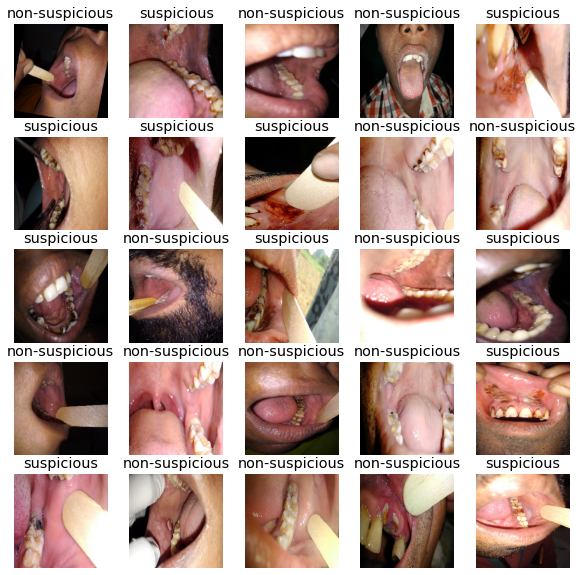

In [25]:

import os
import pathlib
from time import time
# Visualize some images
train_root = pathlib.Path(train_dir)
class_names = sorted([j.name.split('/')[-1] for j in train_root.iterdir()])
class_names = np.array(class_names)
print('Class names: ', class_names)

img_gen = ImageDataGenerator(rescale = 1./255)
sample_train_data_gen = img_gen.flow_from_directory(batch_size = 32,
                                                    directory = train_dir,
                                                    shuffle = True,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(class_names))
                                                 
sample_images, sample_labels = next(sample_train_data_gen)

def show_batch(img_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(class_names[sample_labels[i] == 1][0])
        plt.axis('off')
        
show_batch(sample_images, sample_labels)


In [26]:
train_image_generator = ImageDataGenerator(rescale = 1./255,
                                           rotation_range = 45,
                                           width_shift_range = 0.20,
                                           height_shift_range = 0.20,
                                           horizontal_flip = True,
                                           zoom_range = 0.5)

val_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'categorical')

val_data_gen = val_image_generator.flow_from_directory(batch_size = batch_size,
                                                       directory = val_dir,
                                                       target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode = 'categorical')

test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 1344 images belonging to 2 classes.
Found 412 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [27]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [28]:
EPOCHS = 50
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006
TOTAL_STEPS = 210


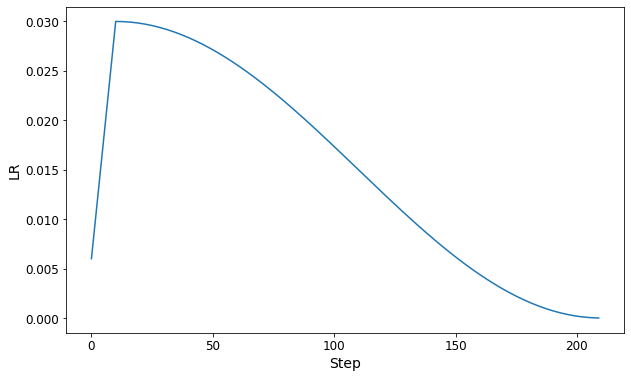

In [29]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [30]:
optimizer = keras.optimizers.Adam(scheduled_lrs)
loss = keras.losses.CategoricalCrossentropy()

In [31]:



# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [32]:
!pip install vit-keras
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=94255b5736cd4a48a47a3cd386b331efd8c9c10c4ad4af3b769377ba1cde1b15
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
!git clone https://github.com/rishigami/Swin-Transformer-TF.git

Cloning into 'Swin-Transformer-TF'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 44 (delta 15), reused 7 (delta 7), pack-reused 26
Unpacking objects: 100% (44/44), 15.88 KiB | 1.22 MiB/s, done.


In [34]:
import tensorflow as tf
import os
import sys
sys.path.append('/content/Swin-Transformer-TF')
from swintransformer import SwinTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
#from vit_keras import vit, utils, visualize


In [35]:
import cv2
from vit_keras import vit, utils, visualize

In [36]:


IMAGE_SIZE = [224, 224, 3]
NUM_CLASSES = 2

swin_vit = SwinTransformer('swin_small_224', include_top=False, pretrained=True)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = IMAGE_SIZE))
model.add(swin_vit)
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
model.build(IMAGE_SIZE)

181072817/181072817 [==============================] - 3s 0us/step


In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [39]:


model_name = "swin(base).h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 15, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=50, 
                                            verbose=3, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [40]:


history = model.fit(train_data_gen,
                    epochs=50,
                    validation_data=val_data_gen,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.6473
Epoch 1: val_loss improved from inf to 0.55092, saving model to swin(base).h5
84/84 [==============================] - 295s 2s/step - loss: 0.6487 - accuracy: 0.6473 - val_loss: 0.5509 - val_accuracy: 0.7233 - lr: 1.0000e-04
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7336
Epoch 2: val_loss improved from 0.55092 to 0.49049, saving model to swin(base).h5
84/84 [==============================] - 186s 2s/step - loss: 0.5472 - accuracy: 0.7336 - val_loss: 0.4905 - val_accuracy: 0.7597 - lr: 1.0000e-04
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4992 - accuracy: 0.7485
Epoch 3: val_loss did not improve from 0.49049
84/84 [==============================] - 184s 2s/step - loss: 0.4992 - accuracy: 0.7485 - val_loss: 0.5609 - val_accuracy: 0.7160 - lr: 1.0000e-04
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.

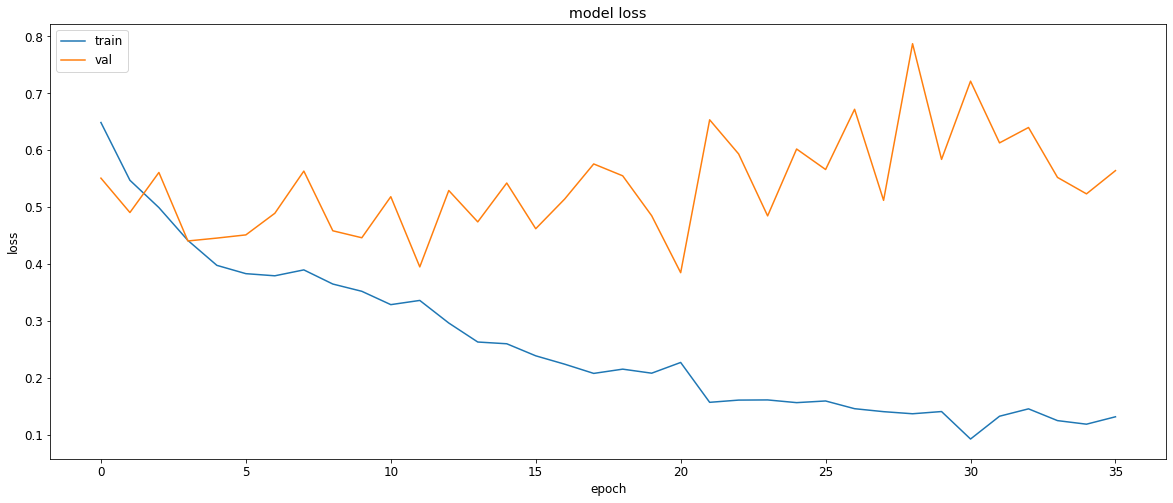

In [41]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

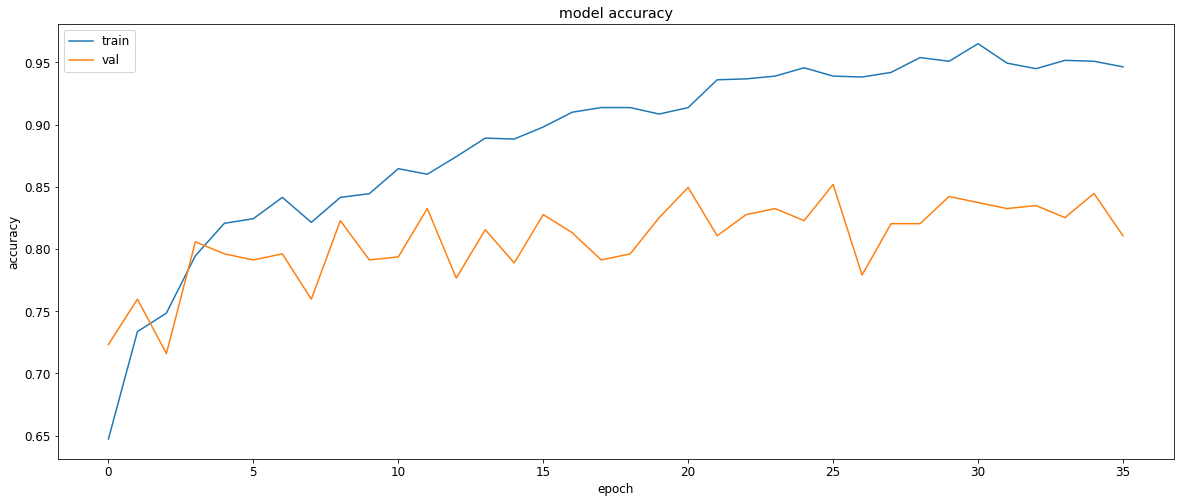

In [42]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:


y_test = test_data_gen.classes
y_preds = model.predict(test_data_gen)
y_pred = np.argmax(y_preds,axis=1)

27/27 [==============================] - 53s 2s/step


In [44]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = classes))

                precision    recall  f1-score   support

non-suspicious       0.89      0.75      0.81       206
    suspicious       0.79      0.91      0.84       216

      accuracy                           0.83       422
     macro avg       0.84      0.83      0.83       422
  weighted avg       0.84      0.83      0.83       422



In [46]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


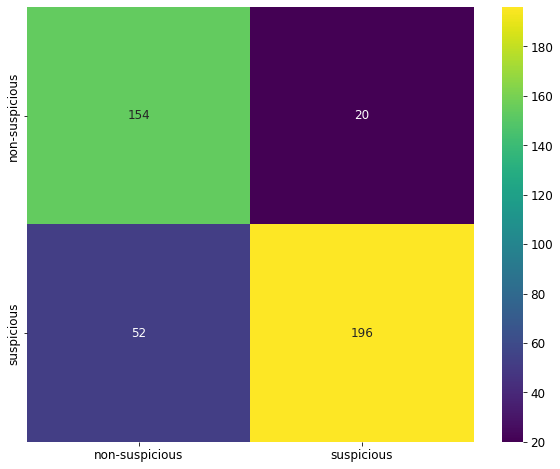

In [47]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt='.3g',xticklabels=classes,yticklabels=classes,cmap='viridis')
plt.show()

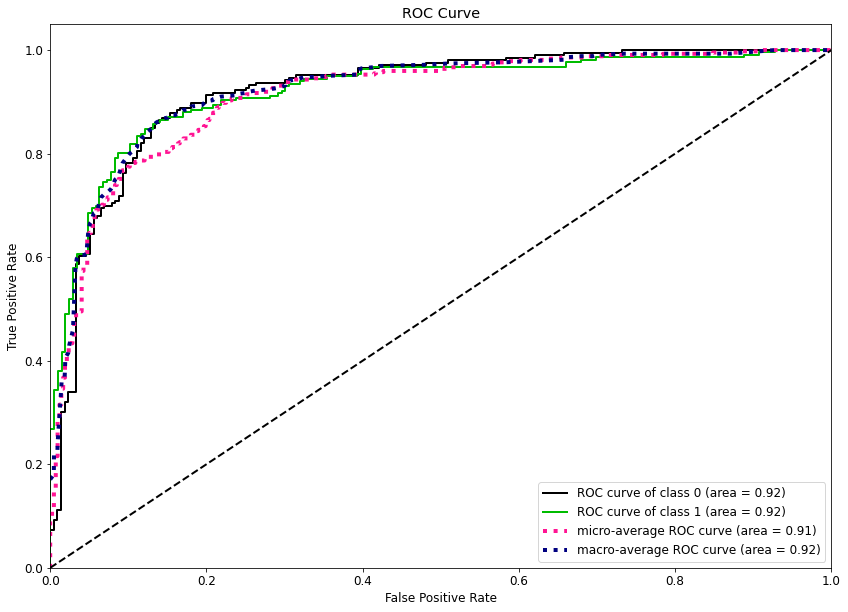

In [48]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# y_test = # ground truth labels
# y_pred = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_preds, figsize=(14,10), 
                            #  curves=('micro'),
                             title='ROC Curve')
plt.show()

In [49]:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.8274901114706941